In [1]:
import re
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import time
from detectors import LSTMDetector
import os
from os import listdir
from os.path import isfile, join

In [2]:
dataset = "SMAP_MSL"
data_path = Path("../data/multivariate/") / dataset
test_df = pd.read_csv(data_path/"labeled_anomalies.csv")
smap_df = test_df.loc[test_df.spacecraft == "SMAP"]
# remove P-2 since anomaly transformer also removes this channel
df = smap_df.loc[smap_df.chan_id != "P-2"]
# msl_df = test_df.loc[test_df.spacecraft == "MSL"]

### SMAP

In [3]:
class Config:
    def __init__(self):
        self.lr = 0.001
        self.num_epochs = 100
        self.win_size = 25
        self.input_c = 1
        self.output_c = 1
        self.batch_size = 64
        self.model_save_path = './LSTM/checkpoints'
        self.data_path = './data_processed/SMAP'
        self.anormly_ratio = 1
        self.dimensions = [0]
        self.dataset = 'SMAP'
        self.lstm_n_predictions = 10
        self.seed = 42
        self.dropout = 0.3
        self.verbose = False
df = smap_df.loc[smap_df.chan_id != "P-2"]
config = Config()
detector = LSTMDetector(config)

anomaly ratio is 8.795 %.
start detection for channel P-1 ..
Number of parameters in the model: 79210
======================TRAIN MODE======================


100%|██████████| 100/100 [00:35<00:00,  2.84it/s]


======================TEST MODE======================


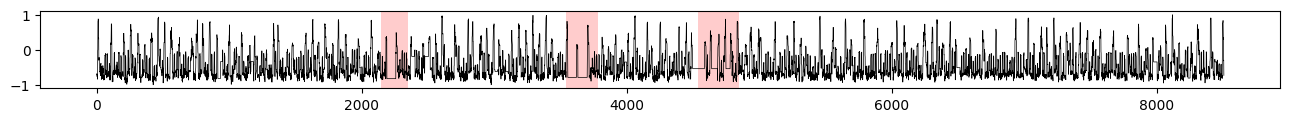

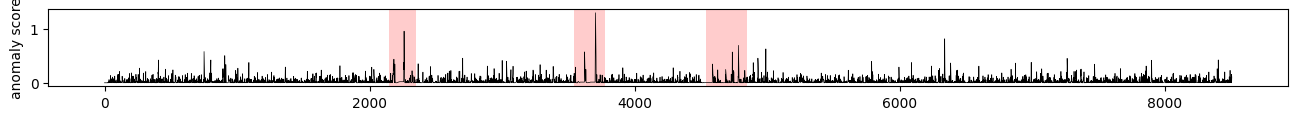

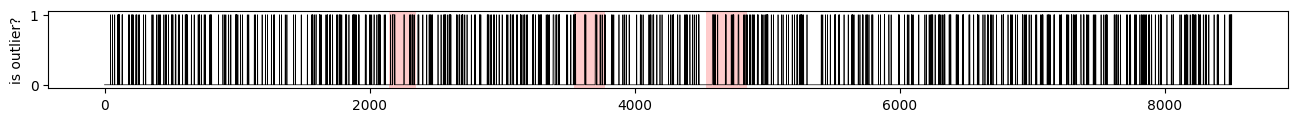

eval w/o point adjustment:
precision: 0.116 recall: 0.116 F1: 0.116 AUC: 0.522
eval with point adjustment:
precision: 0.531 recall: 1.000 F1: 0.694 AUC: 0.522


In [6]:
len_test_dict, len_anomaly_dict, len_ratio_dict = {}, {}, {}
prec_dict, rec_dict, f1_dict, auc_dict, best_f1_dict = {}, {}, {}, {}, {}
prec_adj_dict, rec_adj_dict, f1_adj_dict = {}, {}, {}
time_dict = {}

for channel in df.chan_id:

    if config.dimensions is not None:
        ts_test = np.load(data_path/"test"/f"{channel}.npy")[:,config.dimensions]
    else:
        ts_test = np.load(data_path/"test"/f"{channel}.npy")

    # import ipdb
    # ipdb.set_trace()

    seq_len = len(ts_test)
    anomaly_seqs = df.loc[df.chan_id == channel].anomaly_sequences.to_numpy().item()
    anomaly_seqs = re.findall(r'\d+', anomaly_seqs)
    anomaly_intervals = []
    for i in list(range(0, len(anomaly_seqs), 2)):
        anomaly_intervals.append(anomaly_seqs[i:i+2])
    anomaly_intervals = np.array(anomaly_intervals).astype(int)

    

    ground_truth = np.zeros(ts_test.shape[0])
    plt.figure(figsize=(16,1))
    plt.plot(ts_test, c="k", linewidth=.5)
    for anomaly_points in anomaly_intervals:
        plt.axvspan(anomaly_points[0], anomaly_points[-1], facecolor='red', alpha=.2)
        ground_truth[anomaly_points[0]:anomaly_points[-1]] = 1.

    anomaly_len = sum(ground_truth)
    anomaly_ratio = anomaly_len / seq_len
    print(f"anomaly ratio is {anomaly_ratio * 100.:.3f} %.")

    len_test_dict.update({channel: seq_len})
    len_anomaly_dict.update({channel: anomaly_len})
    len_ratio_dict.update({channel: anomaly_ratio})

    print(f"start detection for channel {channel} ..")
    start_time = time.time()
    anomaly_scores = detector.calculate_anomaly_scores(ts = ts_test, channel_id = channel, contamination = min(anomaly_ratio,0.5)) # contamination has to be inthe range (0.0,0.5]
    end_time = time.time()
    elapsed_time = round(end_time - start_time, 3)
    
    plt.figure(figsize=(16,1))
    loos_viz = np.ones(len(ts_test)) * np.nan
    loos_viz[:len(anomaly_scores)] = anomaly_scores
    plt.plot(loos_viz, c="k", linewidth=.5)
    for anomaly_points in anomaly_intervals:
        plt.axvspan(anomaly_points[0], anomaly_points[-1], facecolor='red', alpha=.2)
        ground_truth[anomaly_points[0]:anomaly_points[-1]] = 1.
    plt.ylabel("anomaly score")
    plt.show()
    
    detected_outliers = anomaly_scores > np.quantile(anomaly_scores, 1-anomaly_ratio) #
    plt.figure(figsize=(16,1))
    loos_viz = np.ones(len(ts_test)) * np.nan
    loos_viz[:len(detected_outliers)] = detected_outliers
    plt.plot(loos_viz, c="k", linewidth=.5)
    for anomaly_points in anomaly_intervals:
        plt.axvspan(anomaly_points[0], anomaly_points[-1], facecolor='red', alpha=.2)
        ground_truth[anomaly_points[0]:anomaly_points[-1]] = 1.
    plt.ylabel("is outlier?")
    plt.show()
    
    prec, rec, f1, auc, prec_adj, rec_adj, f1_adj,  best_f1 = detector.evaluate(ground_truth, anomaly_scores, anomaly_ratio)

    prec_dict.update({channel: prec})
    rec_dict.update({channel: rec})
    f1_dict.update({channel: f1})
    auc_dict.update({channel: auc})
    best_f1_dict.update({channel: best_f1})

    time_dict.update({channel: elapsed_time})

    prec_adj_dict.update({channel: prec_adj})
    rec_adj_dict.update({channel: rec_adj})
    f1_adj_dict.update({channel: f1_adj})

    break # remove this!

smap_metrics = pd.DataFrame({
    "Num_of_Test": len_test_dict,
    "Len_of_Anomaly": len_anomaly_dict,
    "Anomaly_Ratio": len_ratio_dict,
    "Precision(w.o. Adjustment)": prec_dict,
    "Recall(w.o. Adjustment)": rec_dict,
    "F1(w.o. Adjustment)": f1_dict,
    "Precision(w. Adjustment)": prec_adj_dict,
    "Recall(w. Adjustment)": rec_adj_dict,
    "F1(w. Adjustment)": f1_adj_dict,
    "Best_F1_Score": best_f1_dict,
    "AUC": auc_dict,
    'Detection_Time(s)': time_dict
})

smap_metrics.insert(0, "Dataset", smap_metrics.index)
smap_metrics.reset_index(drop = True, inplace = True)

# smap_metrics.to_csv(os.path.join(config.result_path, config.dataset+"_"+config.detector_type+"_results.csv"))

### MSL

In [9]:
class Config:
    def __init__(self):
        self.lr = 0.001
        self.num_epochs = 100
        self.win_size = 25
        self.input_c = 1
        self.output_c = 1
        self.batch_size = 64
        self.model_save_path = './LSTM/checkpoints'
        self.data_path = './data_processed/MSL'
        self.anormly_ratio = 1
        self.dimensions = [0]
        self.dataset = 'MSL'
        self.lstm_n_predictions = 10
        self.seed = 42
        self.dropout = 0.3
        self.verbose = False
df = test_df.loc[test_df.spacecraft == "MSL"]
config = Config()
detector = LSTMDetector(config)

anomaly ratio is 8.785 %.
start detection for channel M-6 ..
Number of parameters in the model: 79210
======================TRAIN MODE======================


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


======================TEST MODE======================


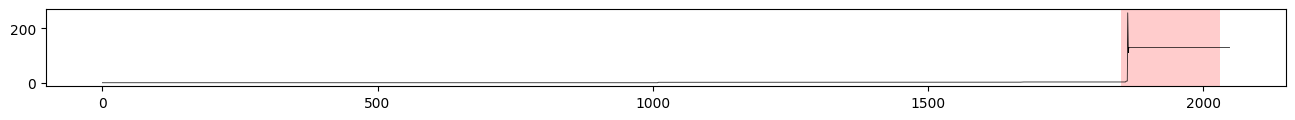

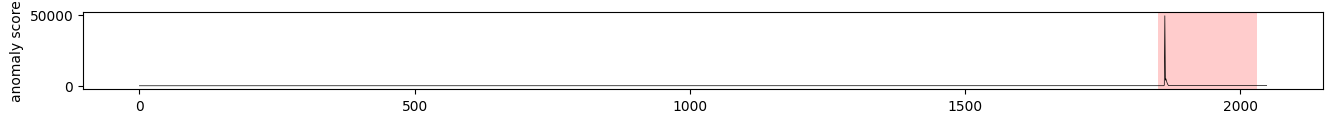

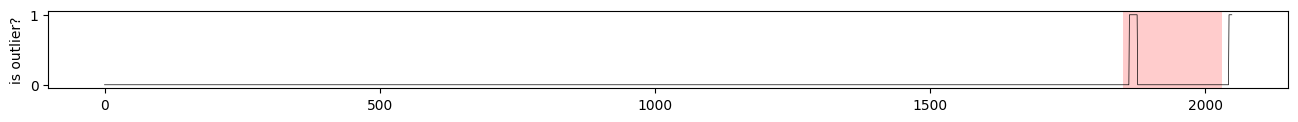

eval w/o point adjustment:
precision: 0.714 recall: 0.083 F1: 0.149 AUC: 0.972
eval with point adjustment:
precision: 0.968 recall: 1.000 F1: 0.984 AUC: 0.972


In [10]:
len_test_dict, len_anomaly_dict, len_ratio_dict = {}, {}, {}
prec_dict, rec_dict, f1_dict, auc_dict, best_f1_dict = {}, {}, {}, {}, {}
prec_adj_dict, rec_adj_dict, f1_adj_dict = {}, {}, {}
time_dict = {}

for channel in df.chan_id:

    if config.dimensions is not None:
        ts_test = np.load(data_path/"test"/f"{channel}.npy")[:,config.dimensions]
    else:
        ts_test = np.load(data_path/"test"/f"{channel}.npy")

    # import ipdb
    # ipdb.set_trace()

    seq_len = len(ts_test)
    anomaly_seqs = df.loc[df.chan_id == channel].anomaly_sequences.to_numpy().item()
    anomaly_seqs = re.findall(r'\d+', anomaly_seqs)
    anomaly_intervals = []
    for i in list(range(0, len(anomaly_seqs), 2)):
        anomaly_intervals.append(anomaly_seqs[i:i+2])
    anomaly_intervals = np.array(anomaly_intervals).astype(int)

    

    ground_truth = np.zeros(ts_test.shape[0])
    plt.figure(figsize=(16,1))
    plt.plot(ts_test, c="k", linewidth=.5)
    for anomaly_points in anomaly_intervals:
        plt.axvspan(anomaly_points[0], anomaly_points[-1], facecolor='red', alpha=.2)
        ground_truth[anomaly_points[0]:anomaly_points[-1]] = 1.

    anomaly_len = sum(ground_truth)
    anomaly_ratio = anomaly_len / seq_len
    print(f"anomaly ratio is {anomaly_ratio * 100.:.3f} %.")

    len_test_dict.update({channel: seq_len})
    len_anomaly_dict.update({channel: anomaly_len})
    len_ratio_dict.update({channel: anomaly_ratio})

    print(f"start detection for channel {channel} ..")
    start_time = time.time()
    anomaly_scores = detector.calculate_anomaly_scores(ts = ts_test, channel_id = channel, contamination = min(anomaly_ratio,0.5)) # contamination has to be inthe range (0.0,0.5]
    end_time = time.time()
    elapsed_time = round(end_time - start_time, 3)
    
    plt.figure(figsize=(16,1))
    loos_viz = np.ones(len(ts_test)) * np.nan
    loos_viz[:len(anomaly_scores)] = anomaly_scores
    plt.plot(loos_viz, c="k", linewidth=.5)
    for anomaly_points in anomaly_intervals:
        plt.axvspan(anomaly_points[0], anomaly_points[-1], facecolor='red', alpha=.2)
        ground_truth[anomaly_points[0]:anomaly_points[-1]] = 1.
    plt.ylabel("anomaly score")
    plt.show()
    
    detected_outliers = anomaly_scores > np.quantile(anomaly_scores, 1-anomaly_ratio) #
    plt.figure(figsize=(16,1))
    loos_viz = np.ones(len(ts_test)) * np.nan
    loos_viz[:len(detected_outliers)] = detected_outliers
    plt.plot(loos_viz, c="k", linewidth=.5)
    for anomaly_points in anomaly_intervals:
        plt.axvspan(anomaly_points[0], anomaly_points[-1], facecolor='red', alpha=.2)
        ground_truth[anomaly_points[0]:anomaly_points[-1]] = 1.
    plt.ylabel("is outlier?")
    plt.show()
    
    prec, rec, f1, auc, prec_adj, rec_adj, f1_adj,  best_f1 = detector.evaluate(ground_truth, anomaly_scores, anomaly_ratio)

    prec_dict.update({channel: prec})
    rec_dict.update({channel: rec})
    f1_dict.update({channel: f1})
    auc_dict.update({channel: auc})
    best_f1_dict.update({channel: best_f1})

    time_dict.update({channel: elapsed_time})

    prec_adj_dict.update({channel: prec_adj})
    rec_adj_dict.update({channel: rec_adj})
    f1_adj_dict.update({channel: f1_adj})

    break # remove this!

smap_metrics = pd.DataFrame({
    "Num_of_Test": len_test_dict,
    "Len_of_Anomaly": len_anomaly_dict,
    "Anomaly_Ratio": len_ratio_dict,
    "Precision(w.o. Adjustment)": prec_dict,
    "Recall(w.o. Adjustment)": rec_dict,
    "F1(w.o. Adjustment)": f1_dict,
    "Precision(w. Adjustment)": prec_adj_dict,
    "Recall(w. Adjustment)": rec_adj_dict,
    "F1(w. Adjustment)": f1_adj_dict,
    "Best_F1_Score": best_f1_dict,
    "AUC": auc_dict,
    'Detection_Time(s)': time_dict
})

smap_metrics.insert(0, "Dataset", smap_metrics.index)
smap_metrics.reset_index(drop = True, inplace = True)



### SMD

In [5]:
dataset = "SMD"
data_path = Path("../data/multivariate/") / dataset
machine_names = [Path(f).stem for f in listdir(data_path/"test") if isfile(join(data_path/"test", f))]

class Config:
    def __init__(self):
        self.lr = 0.001
        self.num_epochs = 100
        self.win_size = 25
        self.input_c = 38
        self.output_c = 38
        self.batch_size = 64
        self.model_save_path = './LSTM/checkpoints'
        self.data_path = './data_processed/SMD'
        self.dataset = 'SMD'
        self.lstm_n_predictions = 10
        self.seed = 42
        self.dropout = 0.3
        self.verbose = False
        self.dimensions = None
config = Config()
detector = LSTMDetector(config)

start detection for server machine-1-1 ..


C:\Users\Evang\AppData\Local\Temp\ipykernel_42436\956340977.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16,1))


anomaly ratio is 9.460 %.
start detection for channel machine-1-1 ..
Number of parameters in the model: 121020
======================TRAIN MODE======================


 12%|█▏        | 12/100 [00:15<01:54,  1.30s/it]

Early stopping triggered
======================TEST MODE======================


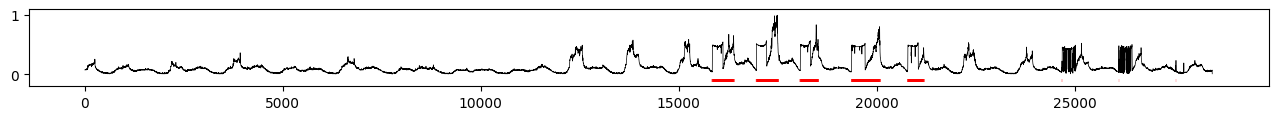

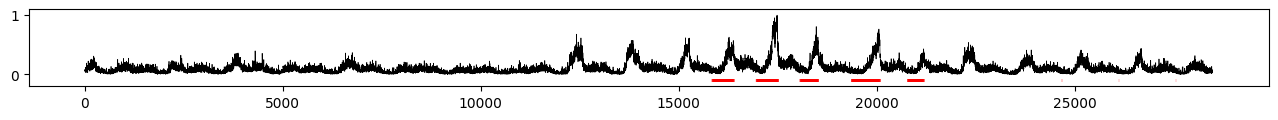

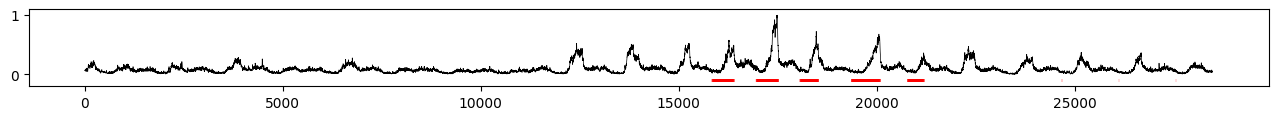

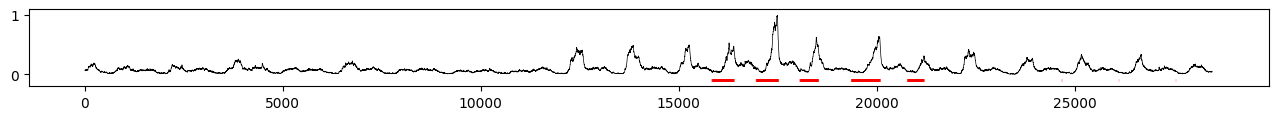

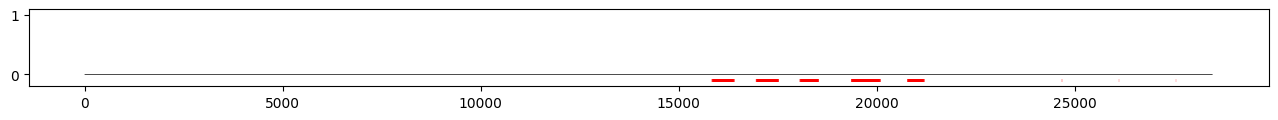

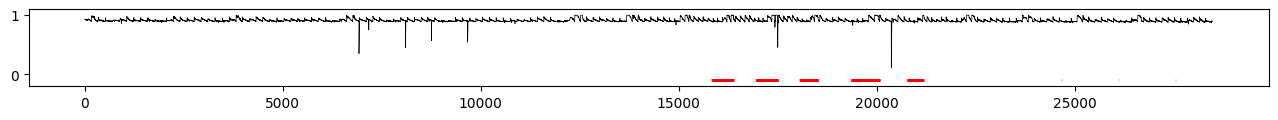

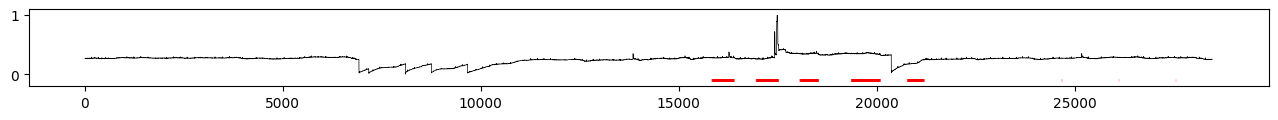

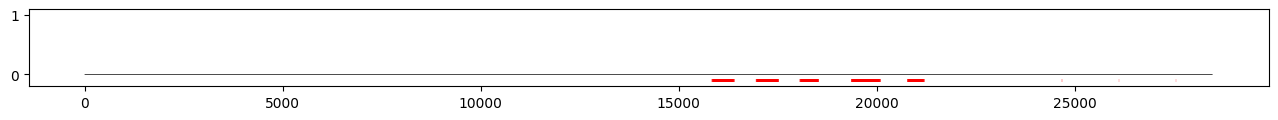

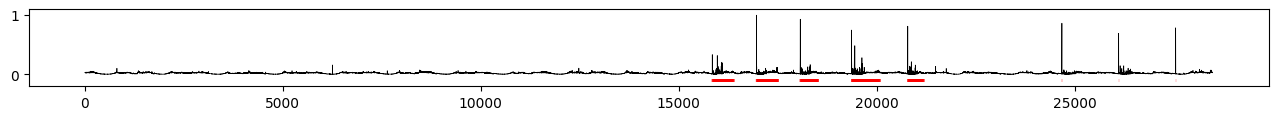

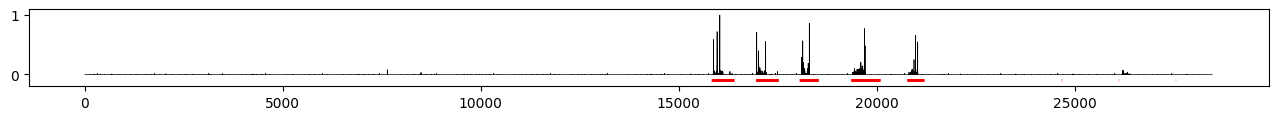

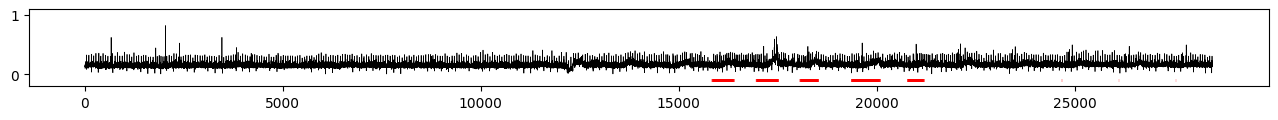

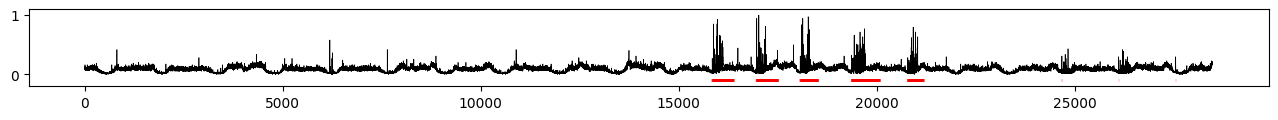

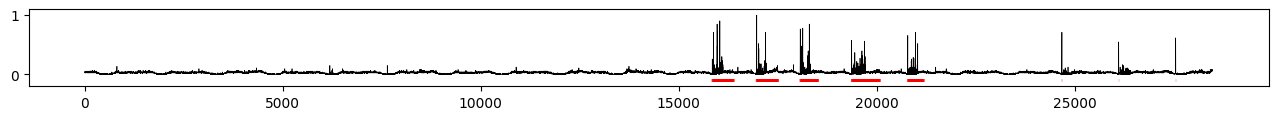

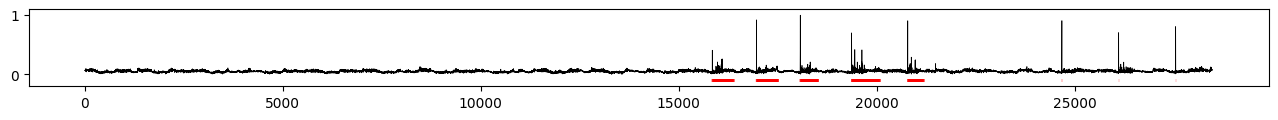

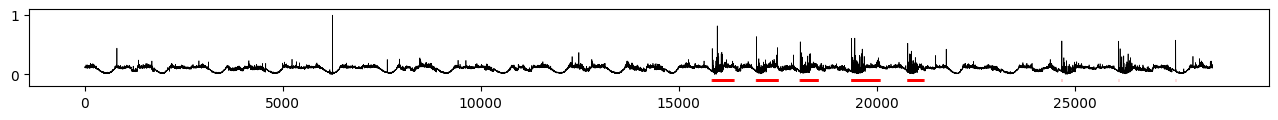

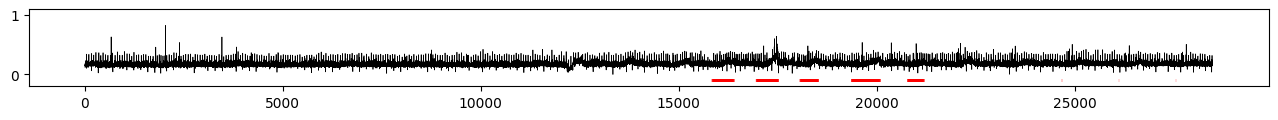

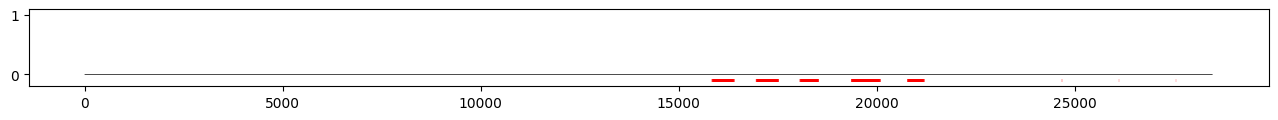

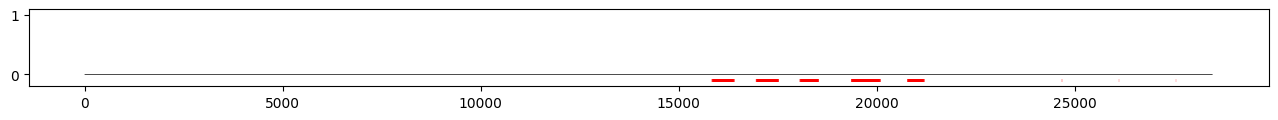

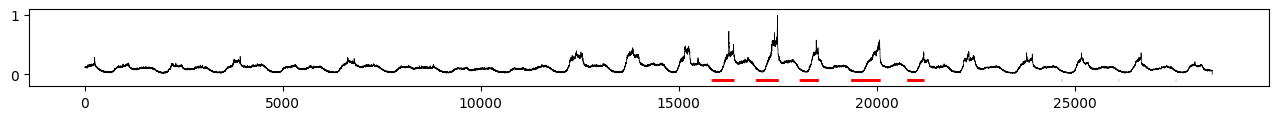

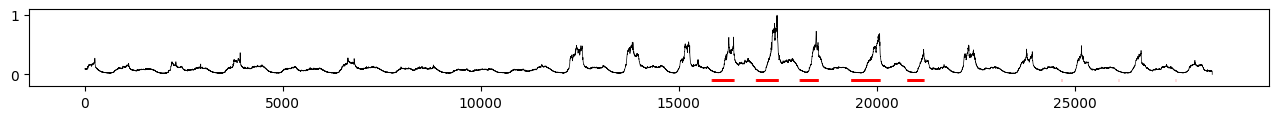

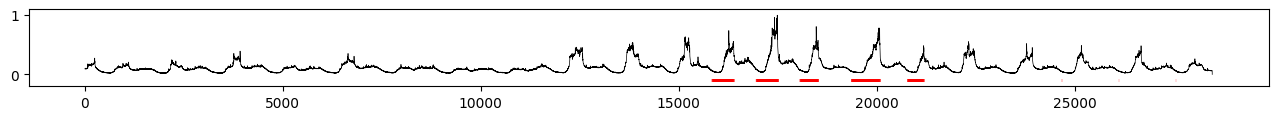

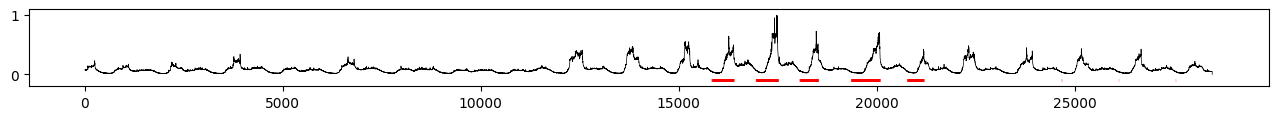

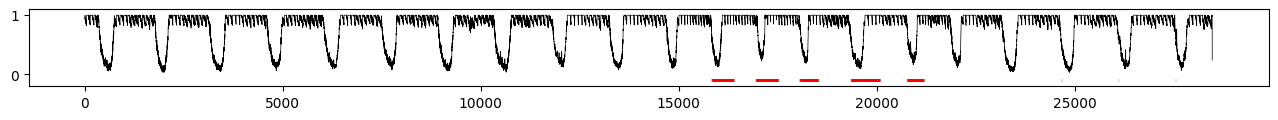

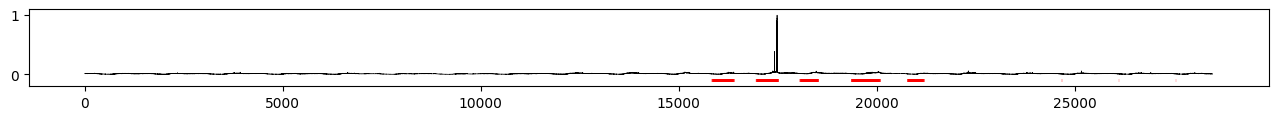

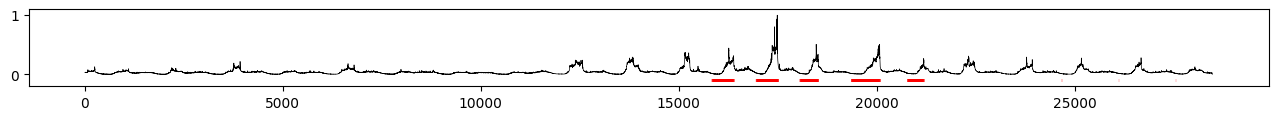

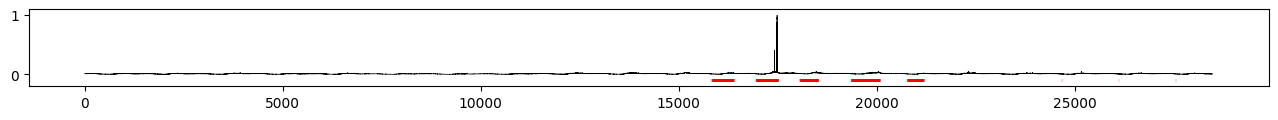

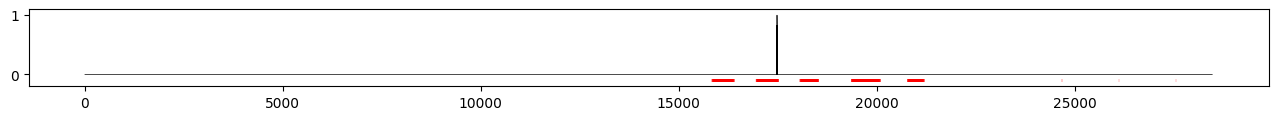

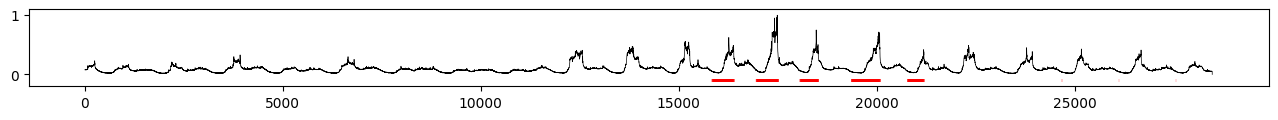

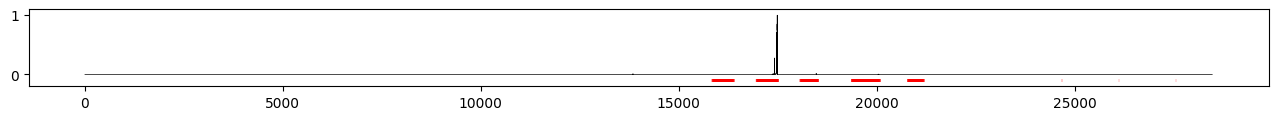

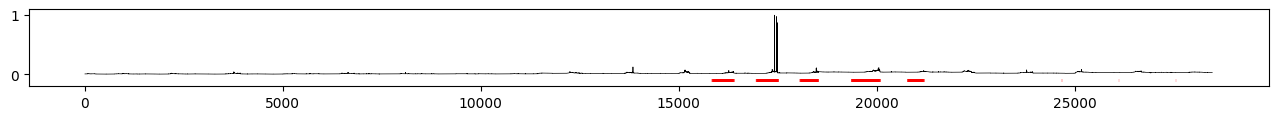

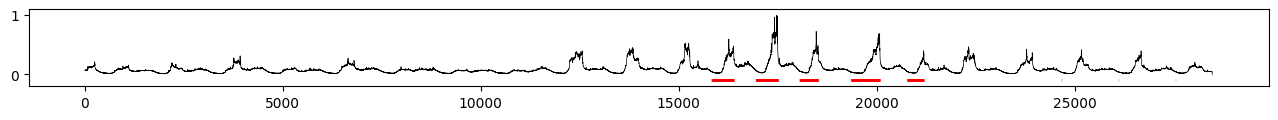

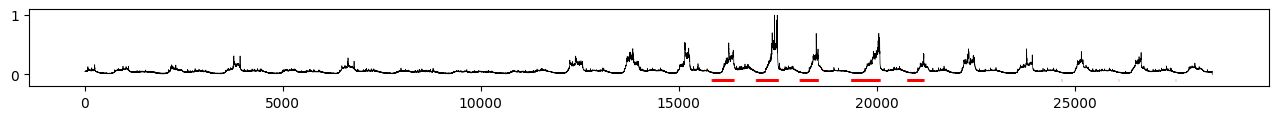

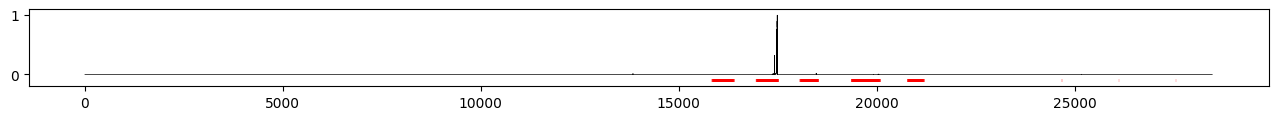

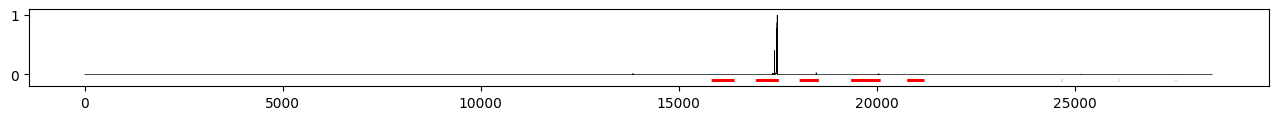

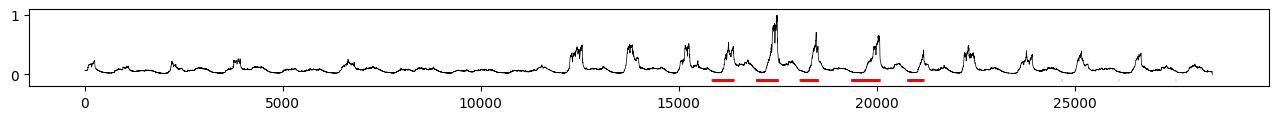

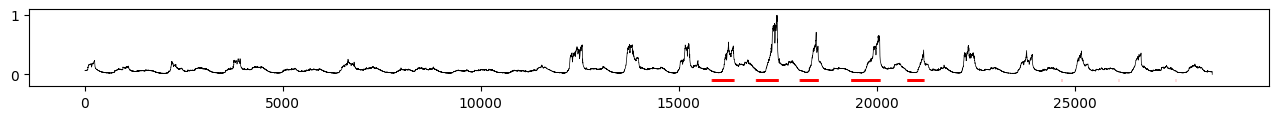

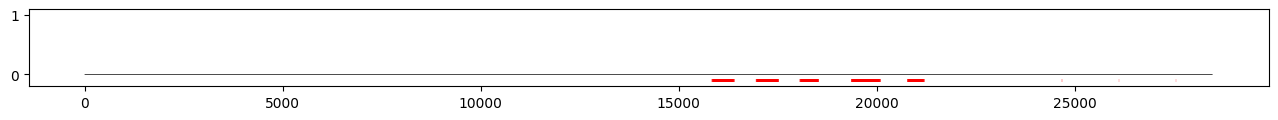

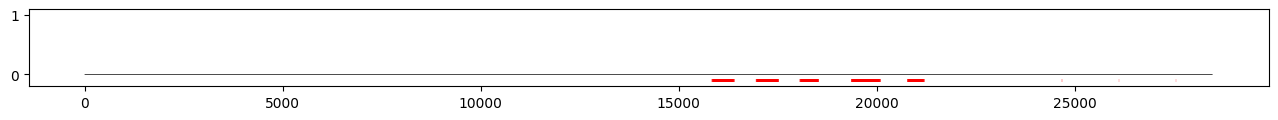

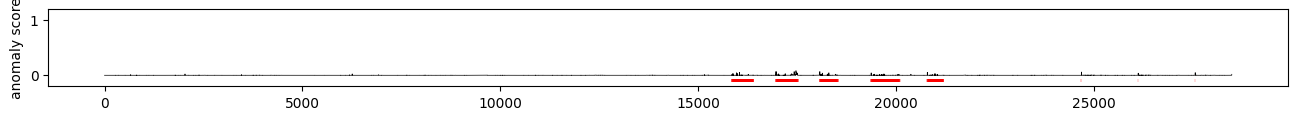

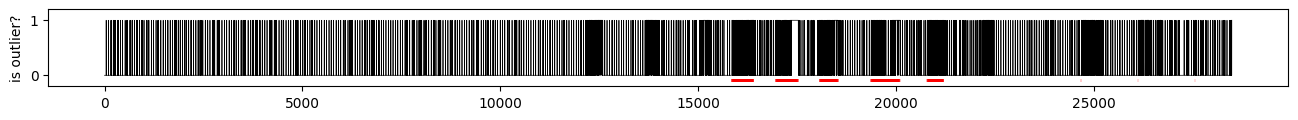

eval w/o point adjustment:
precision: 0.379 recall: 0.379 F1: 0.379 AUC: 0.828
eval with point adjustment:
precision: 0.617 recall: 1.000 F1: 0.763 AUC: 0.828


In [7]:
len_test_dict, len_anomaly_dict, len_ratio_dict = {}, {}, {}
prec_dict, rec_dict, f1_dict, auc_dict, best_f1_dict = {}, {}, {}, {}, {}
prec_adj_dict, rec_adj_dict, f1_adj_dict = {}, {}, {}
time_dict = {}


for channel in machine_names:

    print(f"start detection for server {channel} ..")
    ts_test = pd.read_csv(data_path/"test"/f"{channel}.txt", sep=",", header=None).to_numpy()
    seq_len, n_dim = ts_test.shape
    ground_truth = pd.read_csv(data_path/"test_label"/f"{channel}.txt", sep=",", header=None).to_numpy()
    anomaly_points = np.where(ground_truth == 1)[0]

    for ts in ts_test.T:
        plt.figure(figsize=(16,1))
        plt.plot(ts, c="k", linewidth=.5)
        plt.eventplot(anomaly_points, lineoffsets=-0.1, color='red', linelengths=0.05, linewidths=0.1)
        plt.ylim(-0.2, 1.1)

    anomaly_len = sum(ground_truth)[0]
    anomaly_ratio = anomaly_len / seq_len
    print(f"anomaly ratio is {anomaly_ratio * 100.:.3f} %.")

    len_test_dict.update({channel: seq_len})
    len_anomaly_dict.update({channel: anomaly_len})
    len_ratio_dict.update({channel: anomaly_ratio})

    print(f"start detection for channel {channel} ..")
    start_time = time.time()
    anomaly_scores = detector.calculate_anomaly_scores(ts = ts_test, channel_id = channel, contamination = anomaly_ratio)
    end_time = time.time()
    elapsed_time = round(end_time - start_time, 3)

    plt.figure(figsize=(16,1))
    loos_viz = np.ones_like(ts_test.T[0]) * np.nan
    loos_viz[:len(ts_test)] = anomaly_scores
    plt.plot(loos_viz, c="k", linewidth=.5)
    plt.eventplot(anomaly_points, lineoffsets=-0.1, color='red', linelengths=0.05, linewidths=0.1)
    plt.ylim(-0.2, 1.2)
    plt.ylabel("anomaly score")
    plt.show()

    detected_outliers = anomaly_scores > np.quantile(anomaly_scores, 1-anomaly_ratio)

    plt.figure(figsize=(16,1))
    loos_viz = np.ones_like(ts_test.T[0]) * np.nan
    loos_viz[:len(detected_outliers)] = detected_outliers
    plt.plot(loos_viz, c="k", linewidth=.5)
    plt.eventplot(anomaly_points, lineoffsets=-0.1, color='red', linelengths=0.05, linewidths=0.1)
    plt.ylim(-0.2, 1.2)
    plt.ylabel("is outlier?")
    plt.show()


    prec, rec, f1, auc, prec_adj, rec_adj, f1_adj,  best_f1 = detector.evaluate(ground_truth, anomaly_scores, anomaly_ratio)

    prec_dict.update({channel: prec})
    rec_dict.update({channel: rec})
    f1_dict.update({channel: f1})
    auc_dict.update({channel: auc})
    best_f1_dict.update({channel: best_f1})
    
    time_dict.update({channel: elapsed_time})

    prec_adj_dict.update({channel: prec_adj})
    rec_adj_dict.update({channel: rec_adj})
    f1_adj_dict.update({channel: f1_adj})

    break # remove this!

smd_metrics = pd.DataFrame({
    "Num_of_Test": len_test_dict,
    "Len_of_Anomaly": len_anomaly_dict,
    "Anomaly_Ratio": len_ratio_dict,
    "Precision(w.o. Adjustment)": prec_dict,
    "Recall(w.o. Adjustment)": rec_dict,
    "F1(w.o. Adjustment)": f1_dict,
    "Precision(w. Adjustment)": prec_adj_dict,
    "Recall(w. Adjustment)": rec_adj_dict,
    "F1(w. Adjustment)": f1_adj_dict,
    "Best_F1_Score": best_f1_dict,
    "AUC": auc_dict,
    'Detection_Time(s)': time_dict
})

smd_metrics.insert(0, "Dataset", smd_metrics.index)
smd_metrics.reset_index(drop = True, inplace = True)
    
# smd_metrics.to_csv(os.path.join(config.result_path, config.dataset+"_"+config.detector_type+"_results.csv"))